# Simple notebook for running anomaly detection using tree-based algorithms

**Important NOTE!** This repo uses git Large File Storage (LFS). Make sure that you have installed `git-lfs` via your favourite package manager. After cloning the repo somewhere, run `git lfs install` in the repo root directory. This will set up the git hooks for you. Afterwards, run `git lfs pull` to pull the files.

### Step 1: Run necessary imports

In [1]:
from utils import (load_lhco_rd, multi_roc_sigeffs,
                   train_model_multirun, eval_ensemble)
from plot_utils import plot_sic_curve_comparison

### Step 2: Load data

This loads the data from the `lhco_rd` folder and returns a dictionary containing the data as numpy arrays. In case a user wants to use their own data, they need to write a function also returning a `dict` of numpy arrays. The dictionary keys are required to be those:

- `x_train`: the training data features
- `x_val`: the validation data features
- `x_test`: the test data features
- `y_train_databg`: the weakly supervised "data vs. background" labels for the training data
- `y_train_sigbg`: the fully supervised "signal vs. background" labels for the training data
- `y_val_databg`: the weakly supervised "data vs. background" labels for the validation data
- `y_val_sigbg`: the fully supervised "signal vs. background" labels for the validation data
- `y_test`: the fully supervised "signal vs. background" labels for the test data (here there are no data vs. background labels since it wouldn't really make sense)   

In [2]:
# Load data from LHCO R&D dataset
data = load_lhco_rd("./lhco_rd")

### Step 3: Train the tree-based classifiers

By default, scikit-learn's `HistGradientBoostingClassifier` is used. We do ten runs where each run consists of ten independent trainings. To get the ensemble result, we use the average prediction for each ten-model ensemble. Each model is also trained with a *different* splitting of training and validation set: the percentage split is always 50/50, but each time the assignent is shuffled such that we have some cross-validation as well. The test set (for which the final SIC will be computed) stays always the same. Running the whole training takes around 10 minutes on a modern-era CPU.

In [4]:
# How often to re-run the entire ensemble training procedure
num_runs = 10

# How many models constitute a single ensemble
ensembles_per_model = 10

max_iters = 100

compute_val_weights = True

# Get predictions of all ensembles
full_losses, models = train_model_multirun(
    data,
    num_runs=num_runs, ensembles_per_model=ensembles_per_model,
    max_iters=max_iters, compute_val_weights=compute_val_weights,
    cv_mode="random", early_stopping=True)

full_predictions = eval_ensemble(models, data)
# Get TPRs and FPRs for all ensembles
tpr_vals_noG, fpr_vals_noG = multi_roc_sigeffs(full_predictions, data["y_test"])

Run 1/10
Run 2/10
Run 3/10
Run 4/10
Run 5/10
Run 6/10
Run 7/10
Run 8/10
Run 9/10
Run 10/10


### Step 4: Compute the SIC curve and plot it

No model types provided. Assuming all models are scikit-learn HistGradientBoostingClassifier instances.


/home/lamprecht/code/anna_code_test/lfs_test/treebased_ad/plot_utils.py:30: RuntimeWarning: divide by zero encountered in divide
  multi_sics = multi_tprs/np.sqrt(multi_fprs)
/home/lamprecht/code/anna_code_test/lfs_test/treebased_ad/plot_utils.py:30: RuntimeWarning: invalid value encountered in divide
  multi_sics = multi_tprs/np.sqrt(multi_fprs)
/home/lamprecht/anaconda3/envs/hpopt_optuna/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/lamprecht/anaconda3/envs/hpopt_optuna/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/home/lamprecht/code/anna_code_test/lfs_test/treebased_ad/plot_utils.py:40: RuntimeWarning: divide by zero encountered in divide
  (1/np.sqrt(median_fprs*y_test[y_test == 0].shape[0])) < max_rel_err


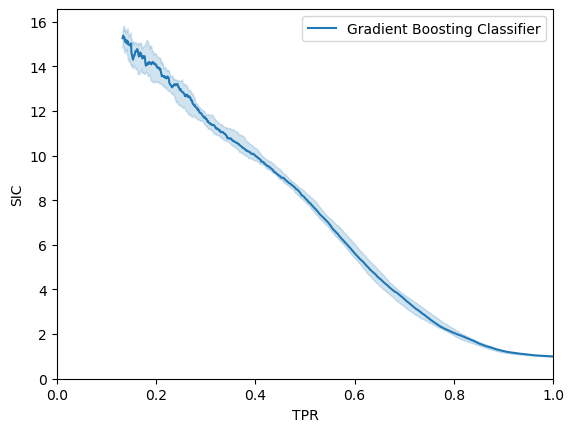

In [5]:
# Plot SIC curves
plot_sic_curve_comparison([models],
                          [data],
                          labels=["Gradient Boosting Classifier"])